### TODO

- Simplify further?
    - Stac search per point instead of the hilbert distances shenanigans
    - Instead of 500 points per thread on a dataloader, just have each thread work on 1 point at a time
- Add error catching to Queued Futures

# Notebook prep

In [1]:
%load_ext autoreload
%autoreload 2

## Import packages

In [2]:
import logging

logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [3]:
import sys
import os
import warnings

sys.path += ["../"]
warnings.filterwarnings("ignore")

In [4]:
from pathlib import Path
import mosaiks.utils as utl
from mosaiks.featurize import RCF

## Setup Rasterio

In [5]:
rasterio_config = utl.load_yaml_config("rasterioc_config.yaml")
os.environ.update(rasterio_config)

# Load params + defaults

In [6]:
featurization_config = utl.load_yaml_config("featurisation.yaml")
satellite_config = utl.load_yaml_config("satellite_config.yaml")
satellite_config = satellite_config[
    featurization_config["satellite_search_params"]["satellite_name"]
]

In [7]:
mosaiks_col_names = [
    f"mosaiks_{i}" for i in range(featurization_config["model"]["num_features"])
]
test_mosaiks_folder_path = Path("test_outputs")

In [8]:
model = RCF(
    featurization_config["model"]["num_features"],
    featurization_config["model"]["kernel_size"],
    len(satellite_config["bands"]),
)

# Load Data

In [9]:
request_points_gdf = utl.load_df_w_latlons_to_gdf(
    dataset_name=featurization_config["coord_set_name"]
)

In [10]:
# Select random 1000 points (for testing)
points_gdf = request_points_gdf.iloc[:1000]

# Simple non-Dask run

In [11]:
test_points_gdf = points_gdf.iloc[1:2]

### Check pipeline run

In [12]:
from mosaiks.run import full_pipeline

In [13]:
%%time
df_1 = full_pipeline(
    test_points_gdf,
    model,
    featurization_config,
    satellite_config,
    col_names=mosaiks_col_names,
    save_folder_path=test_mosaiks_folder_path,
    save_filename="df_TEST.csv",
    return_df=True,
)
df_1

CPU times: user 541 ms, sys: 202 ms, total: 742 ms
Wall time: 1.19 s


,shrid,Lat,Lon,stac_id,mosaiks_0,mosaiks_1,mosaiks_2,mosaiks_3,mosaiks_4,mosaiks_5,...,mosaiks_3990,mosaiks_3991,mosaiks_3992,mosaiks_3993,mosaiks_3994,mosaiks_3995,mosaiks_3996,mosaiks_3997,mosaiks_3998,mosaiks_3999
319819,11-01-000016,34.554878,74.434486,LC08_L2SP_149036_20130518_02_T1,0.0,1.558916,0.0,0.0,2.178435,0.000568,...,5.091597,0.0,3.155938,0.0,6.648977,1.588531,0.007068,2.786207,3.821659,0.000024


### Check pipeline components

In [14]:
from mosaiks.fetch import fetch_image_refs, create_data_loader
from mosaiks.featurize import create_features, make_result_df

In [15]:
%%time
points_gdf_with_stac = fetch_image_refs(
    test_points_gdf, 
    featurization_config['satellite_search_params']
)

CPU times: user 101 ms, sys: 8.06 ms, total: 109 ms
Wall time: 343 ms


In [101]:
from mosaiks.fetch import fetch_image_crop, display_image

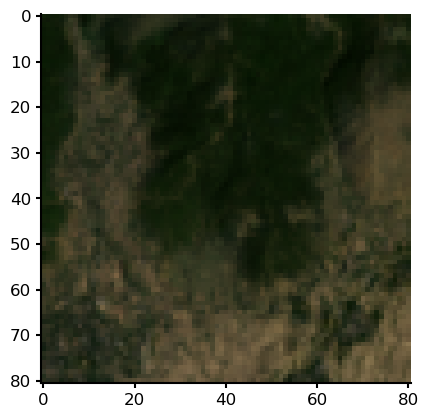

In [50]:
image = fetch_image_crop(
    lon=points_gdf_with_stac.iloc[0]["Lon"],
    lat=points_gdf_with_stac.iloc[0]["Lat"],
    stac_item=points_gdf_with_stac.iloc[0]["stac_item"],
    buffer=satellite_config["buffer_distance"],
    bands=satellite_config["bands"],
    resolution=satellite_config["resolution"],
    dtype=satellite_config["dtype"],
    normalise=True,
)

display_image(image)

In [18]:
# # # for multiple images ######
# for stac_item in points_gdf_with_stac.iloc[0]["stac_item"]:
#     image = fetch_image_crop(
#         lon=points_gdf_with_stac.iloc[0]["Lon"],
#         lat=points_gdf_with_stac.iloc[0]["Lat"],
#         stac_item=stac_item,
#         buffer=satellite_config["buffer_distance"],
#         bands=satellite_config["bands"],
#         resolution=satellite_config["resolution"],
#         dtype="uint16",
#         normalise=True,
#     )

#     display_image(image)

In [19]:
%%time

data_loader = create_data_loader(
    points_gdf_with_stac=points_gdf_with_stac,
    satellite_params=satellite_config,
    batch_size=featurization_config["model"]["batch_size"],
)

CPU times: user 2.24 ms, sys: 0 ns, total: 2.24 ms
Wall time: 2.14 ms


In [20]:
%%time
X_features = create_features(
    dataloader=data_loader,
    n_features=featurization_config["model"]["num_features"],
    model=model,
    device=featurization_config["model"]["device"],
    min_image_edge=satellite_config["min_image_edge"],
)

CPU times: user 138 ms, sys: 124 ms, total: 262 ms
Wall time: 123 ms


In [21]:
%%time
df = make_result_df(
    features=X_features,
    mosaiks_col_names=mosaiks_col_names,
    context_gdf=points_gdf_with_stac,
    context_cols_to_keep=featurization_config["context_cols_to_keep"],
)
df

CPU times: user 3.67 ms, sys: 0 ns, total: 3.67 ms
Wall time: 3.42 ms


,shrid,Lat,Lon,stac_id,mosaiks_0,mosaiks_1,mosaiks_2,mosaiks_3,mosaiks_4,mosaiks_5,...,mosaiks_3990,mosaiks_3991,mosaiks_3992,mosaiks_3993,mosaiks_3994,mosaiks_3995,mosaiks_3996,mosaiks_3997,mosaiks_3998,mosaiks_3999
319819,11-01-000016,34.554878,74.434486,LC08_L2SP_149036_20130518_02_T1,0.0,1.558916,0.0,0.0,2.178435,0.000568,...,5.091597,0.0,3.155938,0.0,6.648977,1.588531,0.007068,2.786207,3.821659,0.000024


In [128]:
%%time
utl.save_dataframe(
    df=df, file_path=test_mosaiks_folder_path/"df_TEST.csv"
)

CPU times: user 6.7 ms, sys: 7.6 ms, total: 14.3 ms
Wall time: 16.3 ms


### Test post-featurization image fetching (for debugging)

In [130]:
# choose featurised data
data = utl.load_dataframe(test_mosaiks_folder_path / "df_000.parquet.gzip")
# data = df

In [131]:
# choose row
row = data.iloc[0]
row

shrid                              11-01-000016
Lat                                   34.554878
Lon                                   74.434486
stac_id         LC08_L2SP_149036_20130518_02_T1
mosaiks_0                                   0.0
                             ...               
mosaiks_3995                           1.588531
mosaiks_3996                           0.007068
mosaiks_3997                           2.786207
mosaiks_3998                           3.821659
mosaiks_3999                           0.000024
Name: 319819, Length: 4004, dtype: object

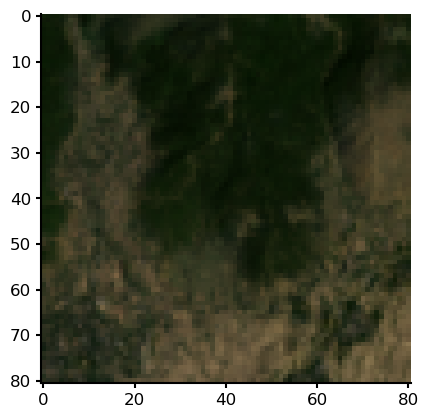

In [126]:
# fetch image crop as per parameters in satellite_config (buffer, bands, etc)
from mosaiks.fetch.images import get_image_crop_from_stac_id

image_crop = get_image_crop_from_stac_id(
    stac_id=row["stac_id"],
    lon=row["Lon"],
    lat=row["Lat"],
    normalise=True,
    satellite_config=satellite_config,
    plot=True,
)

# Dask runs

In [ ]:
### Connect to LOCAL CLIENT
from mosaiks.dask import get_local_dask_client
client = get_local_dask_client(
    featurization_config["dask"]["n_workers"],
    featurization_config["dask"]["threads_per_worker"],
)

In [ ]:
### or connect to GATEWAY
# from mosaiks.dask import get_gateway_cluster_client
# cluster, client = get_gateway_cluster_client()
# cluster

In [ ]:
client

In [24]:
mosaiks_folder_path = Path("test_outputs") #utl.make_output_folder_path(featurization_config)
os.makedirs(mosaiks_folder_path, exist_ok=True)

## Method 1 (Preferred) - Queued Futures

In [ ]:
from mosaiks.dask import run_queued_futures_pipeline

In [ ]:
# %%time

# note that stopping this cell does not stop the dask cluster processing what
# is currently submitted. Use client.restart().
run_queued_futures_pipeline(
    points_gdf.iloc[:10],
    client=client,
    model=model,
    featurization_config=featurization_config,
    satellite_config=satellite_config,
    col_names=mosaiks_col_names,
    save_folder_path=mosaiks_folder_path,
)

## Method 2 - Batched Delayed

In [ ]:
from mosaiks.dask import run_batched_delayed_pipeline

In [ ]:
%%time

# note that stopping this cell does not stop the dask cluster processing what
# is currently submitted. Use client.restart().
run_batched_delayed_pipeline(
    test_points_gdf,
    client=client,
    model=model,
    featurization_config=featurization_config,
    satellite_config=satellite_config,
    col_names=mosaiks_col_names,
    save_folder_path=mosaiks_folder_path,
)

## Method 3 - Unbatched Delayed

In [ ]:
from mosaiks.dask import delayed_pipeline, run_unbatched_delayed_pipeline

### Single task

In [ ]:
delayed_task = delayed_pipeline(
    test_points_gdf,
    model,
    featurization_config,
    satellite_config,
    mosaiks_col_names,
    test_mosaiks_folder_path,
    "TEST_dask_delayed.csv",
)

In [ ]:
delayed_task.visualize(filename=f"{test_mosaiks_folder_path}/TEST_dask_graph.png")

In [ ]:
delayed_task.compute()

### Full run

In [ ]:
delayed_task_list = run_unbatched_delayed_pipeline(
    points_gdf=test_points_gdf,
    client=client,
    model=model,
    featurization_config=featurization_config,
    satellite_config=satellite_config,
    col_names=mosaiks_col_names,
    save_folder_path=mosaiks_folder_path,
)

# Load checkpoint files and combine

In [ ]:
# # simple test
# data = utl.load_dataframe(mosaiks_folder_path / "df_000.parquet.gzip")
# data

In [ ]:
checkpoint_filenames = utl.get_filtered_filenames(
    folder_path=mosaiks_folder_path, prefix="df_"
)
combined_df = utl.load_and_combine_dataframes(
    folder_path=mosaiks_folder_path, filenames=checkpoint_filenames
)
print(f"Dataset size in memory (MB): {combined_df.memory_usage().sum() / 1000000}")

In [ ]:
combined_df

In [ ]:
combined_filepath = mosaiks_folder_path / "combined_features.parquet.gzip"
utl.save_dataframe(df=combined_df, file_path=combined_filepath)